In [1]:
from src.functions.plot_functions import plotar_itens
from src.knapsack_problem.item import gerar_itens_aleatórios
from src.knapsack_problem.knapsack import avaliar_mochila, gerar_mochila_aleatória

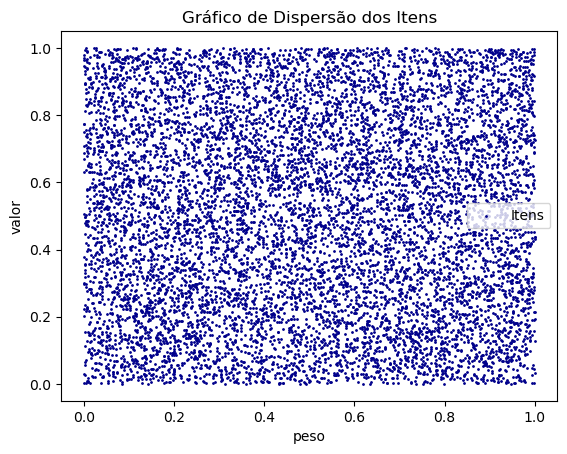

In [2]:
número_de_itens = 10000
valor_mínimo = 0.0
valor_máximo = 1.0
peso_mínimo = 0.0
peso_máximo = 1.0
tipo = float
itens = gerar_itens_aleatórios(número_de_itens=número_de_itens,
                               valor_mínimo=valor_mínimo,
                               valor_máximo=valor_máximo,
                               peso_mínimo=peso_mínimo,
                               peso_máximo=peso_máximo,
                               tipo=tipo,)

plotar_itens(itens)

Total de itens na mochila: 10
Valor total na mochila: 5.003949118523713
Peso total na mochila: 0.9997924160120218


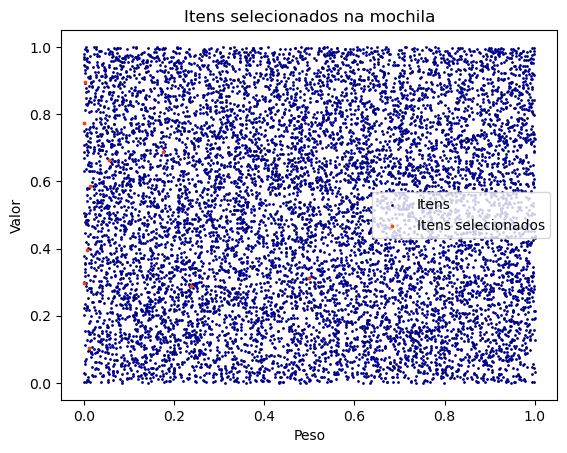

In [3]:
capacidade_das_mochilas = 1.0
mochila_inicial = gerar_mochila_aleatória(capacidade=capacidade_das_mochilas,
                                          itens=itens)
plotar_itens(itens, mochila_inicial)